<a href="https://colab.research.google.com/github/hamza74372/Loan-Default-Prediction/blob/main/Loan_Default_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Please upload your kaggle.json file


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/itsmesunil/bank-loan-modelling
License(s): CC0-1.0
bank-loan-modelling.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  bank-loan-modelling.zip
  inflating: Bank_Personal_Loan_Modelling.xlsx  
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3164, number of negative: 3164
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 799
[LightGBM] [Info] Number of data points in the train set: 6328, number of used features: 11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[50]	valid_0's auc: 0

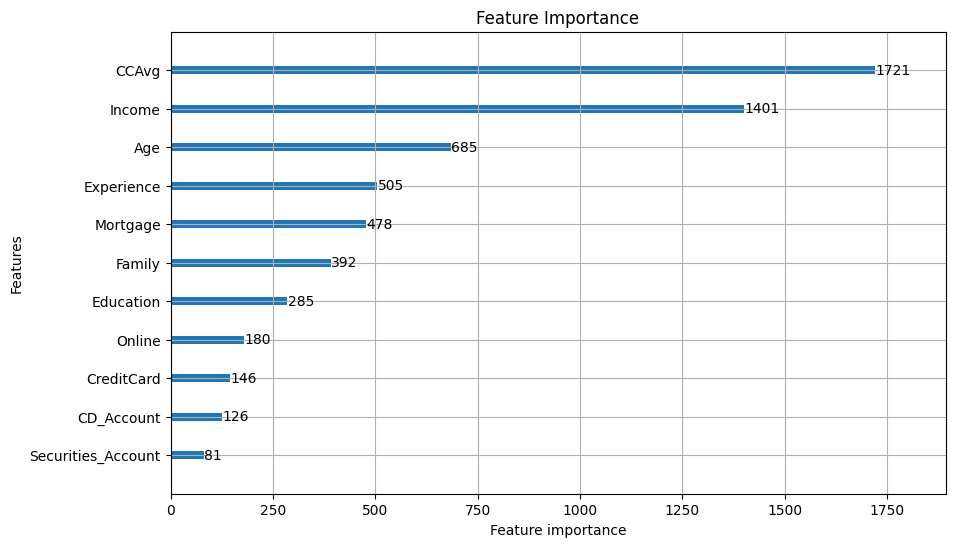

Model saved as 'loan_default_model.pkl'

Sample Prediction: Default Risk
Probability: 99.30%


In [7]:
# -*- coding: utf-8 -*-
"""Loan Default Prediction - Fixed Working Solution.ipynb"""

# Install required packages
!pip install -q kaggle lightgbm imbalanced-learn shap pandas numpy matplotlib seaborn

# ======================
# KAGGLE SETUP
# ======================
from google.colab import files
import os

# Upload kaggle.json
print("Please upload your kaggle.json file")
uploaded = files.upload()

# Setup Kaggle directory
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d itsmesunil/bank-loan-modelling
!unzip -o bank-loan-modelling.zip

# ======================
# DATA PROCESSING
# ======================
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_excel('Bank_Personal_Loan_Modelling.xlsx', sheet_name=1)
df['default'] = df['Personal Loan'].apply(lambda x: 1 if x == 0 else 0)
features = ['Age', 'Experience', 'Income', 'Family', 'CCAvg',
            'Education', 'Mortgage', 'Securities Account',
            'CD Account', 'Online', 'CreditCard']

# ======================
# MODEL TRAINING (FIXED)
# ======================
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

X = df[features]
y = df['default']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Handle class imbalance
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

# Train LightGBM with proper parameters
model = lgb.LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    num_leaves=31,
    learning_rate=0.05,
    n_estimators=200,  # Reduced for faster training
    random_state=42,
    verbose=1  # Set verbosity here instead of in fit()
)

# Fit without problematic parameters
model.fit(
    X_res, y_res,
    eval_set=[(X_test, y_test)],
    eval_metric='auc',
    callbacks=[lgb.log_evaluation(50)]  # Shows progress every 50 iterations
)

# Evaluate
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nROC AUC Score:", roc_auc_score(y_test, y_prob))

# Feature Importance
lgb.plot_importance(model, figsize=(10,6))
plt.title('Feature Importance')
plt.show()

# Save model
import joblib
joblib.dump(model, 'loan_default_model.pkl')
print("Model saved as 'loan_default_model.pkl'")

# Prediction example
sample = pd.DataFrame([{
    'Age': 45,
    'Experience': 20,
    'Income': 100,
    'Family': 2,
    'CCAvg': 2.5,
    'Education': 3,
    'Mortgage': 0,
    'Securities Account': 0,
    'CD Account': 0,
    'Online': 1,
    'CreditCard': 1
}])

prediction = model.predict(sample)
probability = model.predict_proba(sample)[:,1][0]

print(f"\nSample Prediction: {'Default Risk' if prediction[0] else 'Low Risk'}")
print(f"Probability: {probability:.2%}")